In [11]:
%reset

In [12]:
import aegis
import numpy as np
import healpy as hp
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
import sys
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm
from scipy.integrate import quad, simpson

%matplotlib inline

In [13]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [2000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
max_radius = 8.5 + 20*2 #kpc
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = angular_cut*1.5
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [14]:
my_cosmology = 'Planck18'
z_range = [0, 14]
luminosity_range = 10.0**np.array([37, 50]) # Minimum value set by considering Andromeda distance using Fermi as benchmark and receiving 0.1 photon at detector side
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, cosmology = my_cosmology, z_range = z_range, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen, my_AEGIS.Emin_gen, my_AEGIS.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

!!!WARNING!!! Some high energy photons that could be redshifted into the final energy range may not be generated. It is recommended to increase the maximum generating energy


In [15]:
# for spiral galaxies
def ZL_SFG_1(z, l, params): 
    E_photon = 8.09e-04 # erg # average energy of one gamma band photon for SFG # assuming gamma band is 0.1 - 1,000 GeV
    l_erg = l * E_photon # erg/s
    grains=int(1e4)
    log_LIRs = np.linspace(-5, 25, grains)
    log_LIRs_reshaped = log_LIRs[:, np.newaxis, np.newaxis] # Reshape integration grid to allow broadcasting: (grains, 1, 1)
    log_Lgamma = np.log10(l_erg)[np.newaxis, :, :]  # shape (1, 999, 999)

    def Phi_IR(log_LIR): #log_LIR = log_10(L_IR / solar_luminosity) # unitless

        # from Table 8 in Gruppioni et al.
        Phi_star = 10**(-2.12) # Mpc^{-3} dex^{-1}
        L_star = 10**(9.78) # Solar luminosity
        alpha = 1.00
        sigma = 0.50

        LIR = 10**log_LIR # solar luminosity

        Phi_IR = Phi_star * (LIR / L_star)**(1 - alpha) * np.exp(-1 / (2 * sigma**2) * (np.log10(1 + LIR / L_star))**2) # from Gruppioni paper eqn (3)  	

        return Phi_IR
    
    def PDF_log_Lgamma_given_log_LIR(log_LIR): #log_LIR = log_10(L_IR / solar_luminosity) # unitless
        LIR_solar_luminosity = 10**log_LIR # Solar luminosity; shape (grains,1,1)
        L_IR_erg_second = LIR_solar_luminosity * 3.826e33 # erg/s

        a = 1.09
        g = 40.8
        sigma_SF = 0.202 

        mean = g + a * np.log10(L_IR_erg_second / 1e45) # Compute mean from the integration variable; shape (grains, 1, 1)
        std = sigma_SF  # scalar

        return norm.pdf(log_Lgamma, loc=mean, scale=std)
    
    # Compute Phi_IR on the integration grid, and reshape to (grains, 1, 1) for broadcasting
    Phi_vals = Phi_IR(log_LIRs)[:, np.newaxis, np.newaxis]  # shape (grains, 1, 1)

    # Compute the PDF values; result shape (grains, 999, 999)
    pdf_vals = PDF_log_Lgamma_given_log_LIR(log_LIRs_reshaped)

    # Multiply to get the integrand; shape (grains, 999, 999)
    integrands = Phi_vals * pdf_vals

    # Perform Simpson integration along the integration axis (axis=0)
    LF = simpson(integrands, x=log_LIRs, axis=0)  # resulting shape (999, 999)

    return 1e-9 / np.log(10) / l * LF # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9


def spec_SFG_1(energy, params):
    Gamma = 2.2
    return energy**(-Gamma)


In [16]:
# for starburst galaxies
def ZL_SFG_2(z, l, params): 
    E_photon = 8.09e-04 # erg # average energy of one gamma band photon for SFG # assuming gamma band is 0.1 - 1,000 GeV
    l_erg = l * E_photon # erg/s
    grains=int(1e4)
    log_LIRs = np.linspace(-5, 25, grains)
    log_LIRs_reshaped = log_LIRs[:, np.newaxis, np.newaxis] # Reshape integration grid to allow broadcasting: (grains, 1, 1)
    log_Lgamma = np.log10(l_erg)[np.newaxis, :, :]  # shape (1, 999, 999)

    def Phi_IR(log_LIR): #log_LIR = log_10(L_IR / solar_luminosity) # unitless

        # from Table 8 in Gruppioni et al.
        Phi_star = 10**(-4.46) # Mpc^{-3} dex^{-1}
        L_star = 10**(11.17) # Solar luminosity
        alpha = 1.00
        sigma = 0.35

        LIR = 10**log_LIR # solar luminosity

        Phi_IR = Phi_star * (LIR / L_star)**(1 - alpha) * np.exp(-1 / (2 * sigma**2) * (np.log10(1 + LIR / L_star))**2) # from Gruppioni paper eqn (3)  	

        return Phi_IR
    
    def PDF_log_Lgamma_given_log_LIR(log_LIR): #log_LIR = log_10(L_IR / solar_luminosity) # unitless
        LIR_solar_luminosity = 10**log_LIR # Solar luminosity; shape (grains,1,1)
        L_IR_erg_second = LIR_solar_luminosity * 3.826e33 # erg/s

        a = 1.09
        g = 40.8
        sigma_SF = 0.202 

        mean = g + a * np.log10(L_IR_erg_second / 1e45) # Compute mean from the integration variable; shape (grains, 1, 1)
        std = sigma_SF  # scalar

        return norm.pdf(log_Lgamma, loc=mean, scale=std)
    
    # Compute Phi_IR on the integration grid, and reshape to (grains, 1, 1) for broadcasting
    Phi_vals = Phi_IR(log_LIRs)[:, np.newaxis, np.newaxis]  # shape (grains, 1, 1)

    # Compute the PDF values; result shape (grains, 999, 999)
    pdf_vals = PDF_log_Lgamma_given_log_LIR(log_LIRs_reshaped)

    # Multiply to get the integrand; shape (grains, 999, 999)
    integrands = Phi_vals * pdf_vals

    # Perform Simpson integration along the integration axis (axis=0)
    LF = simpson(integrands, x=log_LIRs, axis=0)  # resulting shape (999, 999)

    return 1e-9 / np.log(10) / l * LF # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9




def spec_SFG_2(energy, params):
    Gamma = 2.2
    return energy**(-Gamma)


In [17]:
# for SF-AGN galaxies
def ZL_SFG_3(z, l, params): 
    E_photon = 8.09e-04 # erg # average energy of one gamma band photon for SFG # assuming gamma band is 0.1 - 1,000 GeV
    l_erg = l * E_photon # erg/s
    grains=int(1e4)
    log_LIRs = np.linspace(-5, 25, grains)
    log_LIRs_reshaped = log_LIRs[:, np.newaxis, np.newaxis] # Reshape integration grid to allow broadcasting: (grains, 1, 1)
    log_Lgamma = np.log10(l_erg)[np.newaxis, :, :]  # shape (1, 999, 999)

    def Phi_IR(log_LIR): #log_LIR = log_10(L_IR / solar_luminosity) # unitless

        # from Table 8 in Gruppioni et al.
        Phi_star = 10**(-3.20) # Mpc^{-3} dex^{-1}
        L_star = 10**(10.80) # Solar luminosity
        alpha = 1.20
        sigma = 0.40

        LIR = 10**log_LIR # solar luminosity

        Phi_IR = Phi_star * (LIR / L_star)**(1 - alpha) * np.exp(-1 / (2 * sigma**2) * (np.log10(1 + LIR / L_star))**2) # from Gruppioni paper eqn (3)  	

        return Phi_IR
    
    def PDF_log_Lgamma_given_log_LIR(log_LIR): #log_LIR = log_10(L_IR / solar_luminosity) # unitless
        LIR_solar_luminosity = 10**log_LIR # Solar luminosity; shape (grains,1,1)
        L_IR_erg_second = LIR_solar_luminosity * 3.826e33 # erg/s

        a = 1.09
        g = 40.8
        sigma_SF = 0.202 

        mean = g + a * np.log10(L_IR_erg_second / 1e45) # Compute mean from the integration variable; shape (grains, 1, 1)
        std = sigma_SF  # scalar

        return norm.pdf(log_Lgamma, loc=mean, scale=std)
    
    # Compute Phi_IR on the integration grid, and reshape to (grains, 1, 1) for broadcasting
    Phi_vals = Phi_IR(log_LIRs)[:, np.newaxis, np.newaxis]  # shape (grains, 1, 1)

    # Compute the PDF values; result shape (grains, 999, 999)
    pdf_vals = PDF_log_Lgamma_given_log_LIR(log_LIRs_reshaped)

    # Multiply to get the integrand; shape (grains, 999, 999)
    integrands = Phi_vals * pdf_vals

    # Perform Simpson integration along the integration axis (axis=0)
    LF = simpson(integrands, x=log_LIRs, axis=0)  # resulting shape (999, 999)

    return 1e-9 / np.log(10) / l * LF # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9



def spec_SFG_3(energy, params):
    Gamma = 2.2
    return energy**(-Gamma)


In [18]:
# for mAGN
def ZL_mAGN(z, l, params): 
    E_photon = 8.09e-04 # erg # average energy of one gamma band photon for SFG # assuming gamma band is 0.1 - 1,000 GeV
    l_erg = l * E_photon # erg/s
    res=int(1e4)
    log_L5Gs = np.linspace(20, 55, res) # L_5GHz is measured in erg/s
    # Reshape integration grid to broadcast: (res, 1, 1)
    log_L5Gs_reshaped = log_L5Gs[:, np.newaxis, np.newaxis]
    # Compute log_Lgamma from l_erg and reshape to (1, 999, 999) for broadcasting
    log_Lgamma = np.log10(l_erg)[np.newaxis, :, :]  # shape becomes (1, 999, 999)

    def Phi_5G(log_L5G, z): #log_L5G = log_10(L_5GHz / (erg/s)) # unitless
        #Output is in Mpc^{-3}

        L_5G = 10**log_L5G # erg/s
        radio_bandwidth = 4.87e9 # measured in Hz # width of radio band centered around blueshifted frequency of 5GHz 
        diff_L5G = L_5G / radio_bandwidth * 1e-7 # measured in W/Hz # Converted erg to Joule # luminosity per unit frequency

        # Values taken from Table 4 of Yuan 2018 paper. Second row.
        p1 = 2.085
        p2 = -4.602
        z_c = 0.893
        k1 = 1.744
        e1 = ( (1+z_c)**p1 + (1+z_c)**p2 ) / ( ((1+z_c)/(1+z))**p1 + ((1+z_c)/(1+z))**p2 )
        e2 = (1+z)**k1
        phi1 = 10**-3.749 # Mpc^{-3}
        L_star = 10**21.592 # W/Hz
        beta = 0.139
        gamma = 0.878

        # From Yuan 2018 paper equation 21
        # Note that this is dN/dV dlog(diff_5G). But this is also equal to dN/dV dlog(L_5G) because the radio bandwidth is fixed.
        Phi_5G = e1 * phi1 * ( (diff_L5G / (e2 * L_star))**beta + (diff_L5G / (e2 * L_star))**gamma )**-1

        return Phi_5G # Expected shape: same as log_L5G input (e.g., (res,1,1))
    
    def PDF_log_Lgamma_given_log_L5G(log_L5G, log_Lgamma): #log_L5G = log_10(L_5GHz / (erg/s)) # unitless
        L_5GHz = 10**log_L5G # erg/s

        b = 0.78
        d = 40.78
        sigma_mAGN = 0.880

        mean = d + b * np.log10(L_5GHz / 1e40)
        std = sigma_mAGN

        return norm.pdf(log_Lgamma, loc=mean, scale=std) # shape: (res, 999, 999)
    
    def integrand(log_L5G, z, log_Lgamma):
        return Phi_5G(log_L5G, z) * PDF_log_Lgamma_given_log_L5G(log_L5G, log_Lgamma)
    
    # Evaluate the integrand with broadcasting.
    # log_L5Gs_reshaped has shape (res, 1, 1), and log_Lgamma has shape (1, 999, 999)
    integrand_vals = integrand(log_L5Gs_reshaped, z, log_Lgamma)  # shape: (res, 999, 999)
    
    # LF takes as input 'z' and 'log_{10}(L_gamma)' and outputs the gamma LF in the form dN/dV/dlogL
    # Now integrate along the first axis (the integration variable axis)
    LF = simpson(integrand_vals, x=log_L5Gs, axis=0)  # result has shape (999, 999)

    return 1e-9 / np.log(10) / l * LF # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9



def spec_mAGN(energy, params):
    Gamma = 2.25
    return energy**(-Gamma)

In [19]:
als_SFG1 = [ZL_SFG_1, spec_SFG_1]
als_SFG2 = [ZL_SFG_2, spec_SFG_2]
als_SFG3 = [ZL_SFG_3, spec_SFG_3]
als_mAGN = [ZL_mAGN, spec_mAGN]

my_AEGIS.abun_lum_spec = [als_SFG1, als_SFG2, als_SFG3, als_mAGN]
my_AEGIS.source_class_list = ['extragalactic_isotropic_faint_single_spectrum', 'extragalactic_isotropic_faint_single_spectrum', 'extragalactic_isotropic_faint_single_spectrum', 'extragalactic_isotropic_faint_single_spectrum']

In [20]:
input_params = [] 

source_info = my_AEGIS.create_sources(input_params, grains=100, epsilon=1e-2) 
photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info, grains=100) 

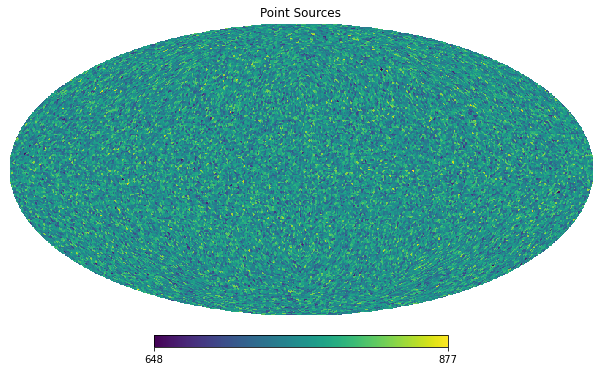

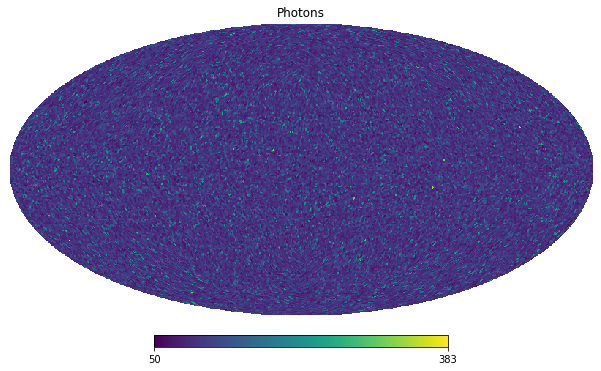

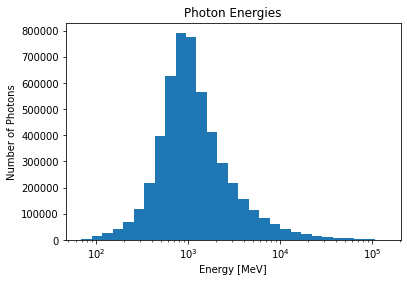

Number of sources:  37524182
Number of photons:  5136674
Average photon energy:  2.119599555344156  GeV
Average luminosity/source:  4.545374117915494e+42 $ erg s^{-1}$
Approximate Flux:  1.3819179534078186e-07 $ erg cm^{-2}s^{-1}$
Size of pixels (deg): 0.9161297098179749


In [21]:

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Point Sources')

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Photons')


#-----------------------------------------------------------------------------------------------


#-----------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_title('Photon Energies')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
bins = np.geomspace(photon_info['energies'].min(), photon_info['energies'].max(), 30)
ax.hist(photon_info['energies'], bins = bins, range = energy_range_gen)
plt.xscale('log')
plt.show()

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(photon_info['energies']))
print('Average photon energy: ', np.mean(photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source: ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(photon_info['energies'])*u.MeV.to('erg')*np.size(photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

My Code to generate energy-dependent histogram

In [ ]:
# N_pix = 12*N_side**2
# N_Ebins = 10
# obs_info = {'psf_fits_path': 'FERMI_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': 'FERMI_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
# obs_photon_info = my_AEGIS.mock_observe(photon_info, obs_info)
# photon_pixels = hp.ang2pix(N_side, obs_photon_info['angles'][:,0], obs_photon_info['angles'][:,1])
# photon_energies = obs_photon_info['energies']
# pix_bins = np.linspace(0, N_pix, N_pix+1)
# E_bins = np.geomspace(energy_range[0], energy_range[1], N_Ebins+1)
# print(f"energy_range[0] = {energy_range[0]}, energy_range[1] = {energy_range[1]}")

# # Define bins for the counts per pixel (adjust max value as needed)
# counts_bins = np.array([0,1,2,4, 6,8, 10, 15, 25, 37])  # This creates bin edges [0, 1, 2, ..., 14]

# # Create an array of energy bin indices for each photon:
# # np.digitize returns indices starting at 1, so subtract 1 to make it 0-indexed.
# E_bin_index = np.digitize(photon_energies, bins=E_bins) - 1

# # Initialize a 2D array to hold the histogram for each energy bin.
# # Rows correspond to counts per pixel and columns correspond to energy bins.
# hist2d = np.zeros((len(counts_bins) - 1, N_Ebins))

# # Loop over energy bins to compute the histogram of pixel counts.
# for i in range(N_Ebins):
#     # Select photons that belong to the i-th energy bin.
#     mask = (E_bin_index == i)
#     pixels_in_bin = photon_pixels[mask]
    
#     # Create a counts map: count the number of photons in each pixel.
#     counts_map = np.bincount(pixels_in_bin, minlength=N_pix)
#     print(f"max counts = {counts_map.max()}")
    
#     # Compute the histogram of pixel counts (i.e. number of pixels having 0, 1, 2, ... photons)
#     hist_counts, _ = np.histogram(counts_map, bins=counts_bins)
    
#     # Store the histogram in the corresponding column.
#     hist2d[:, i] = hist_counts

energy_range[0] = 2000, energy_range[1] = 100000
max counts = 35
max counts = 25
max counts = 16
max counts = 11
max counts = 14
max counts = 7
max counts = 5
max counts = 6
max counts = 4
max counts = 3


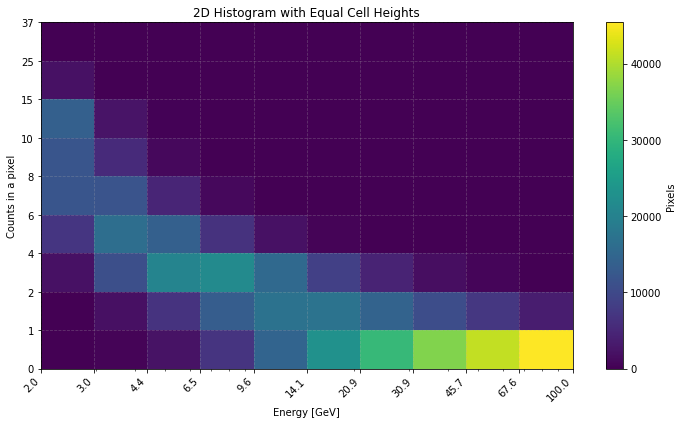

In [ ]:
# # Create transformed y-axis edges for equal cell heights
# y_edges = np.arange(len(counts_bins))  # [0, 1, 2, ..., m]

# plt.figure(figsize=(10, 6))
# mesh = plt.pcolormesh(E_bins, y_edges, hist2d, shading='flat', cmap='viridis')

# # Add colorbar
# cbar = plt.colorbar(mesh)
# cbar.set_label('Pixels')

# # Configure axes
# plt.xscale('log')  # Energy axis is log-scaled

# # Label x-axis with E_bins (rotated for readability)
# plt.xticks(E_bins, labels=[f"{val/1000:.1f}" for val in E_bins], rotation=45, ha='right')

# # Label y-axis with counts_bins (top/bottom edges of cells)
# plt.yticks(y_edges, counts_bins)

# plt.xlabel('Energy [GeV]')
# plt.ylabel('Counts in a pixel')
# plt.title('2D Histogram with Equal Cell Heights')
# plt.grid(visible=True, axis='both', linestyle='--', alpha=0.3)
# plt.tight_layout()  # Adjust spacing
# plt.show()

Kat's code to generate energy-dependent histogram

Custom


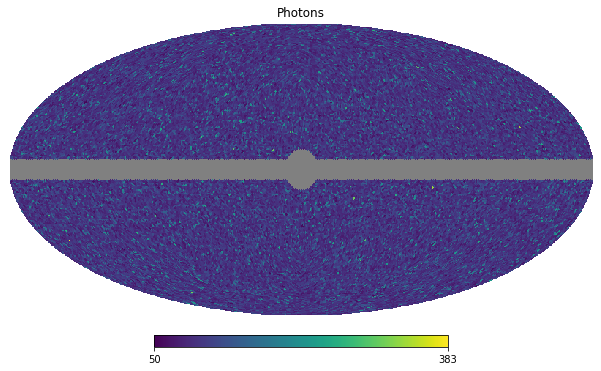

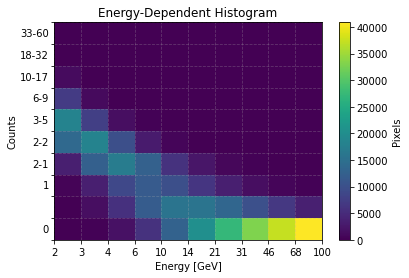

In [26]:
#parameters for the summary statistic
center_mask = 10 #deg
lat_mask = 5 #deg
N_Ebins = 10
Ebinspace = 'log'#'linear'
N_countbins = 10
countbinspace = 'custom'#'linear'
mincount, maxcount = 0, 60

N_pix = 12*N_side**2
pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]
roi_map = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = Ebinspace, roi_pix_i = roi_pix_i)
summary = my_AEGIS.get_counts_histogram_from_roi_map(roi_map, mincount = mincount, maxcount = maxcount, N_countbins = N_countbins, countbinspace = countbinspace)


# You can use the code below to plot the masked map and the summary statistic. Then you can feed the summary above into sbi for training.


heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
masked_map = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')), heatmap[0], hp.UNSEEN)
hp.mollview(masked_map, title = 'Photons')

import matplotlib.ticker as ticker
if Ebinspace == 'linear':
    Ebins = np.linspace(my_AEGIS.Emin_mask, my_AEGIS.Emax_mask, N_Ebins + 1)
elif Ebinspace == 'log':
    Ebins = np.geomspace(my_AEGIS.Emin_mask + 0.1, my_AEGIS.Emax_mask + 0.1, N_Ebins + 1) - 0.1
countbins = np.geomspace(mincount + 0.1, maxcount + 0.1, N_countbins + 1) - 0.1
fig, ax = plt.subplots()
ax.set_title('Energy-Dependent Histogram')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('Counts', labelpad = 30)
ax.set_xticks(np.linspace(0, N_Ebins, N_Ebins+1))
ax.set_yticks(np.linspace(0, N_countbins, N_countbins+1))
ax.set_xticklabels(np.round(Ebins/1000).astype('int'))
count_ints = np.round(countbins).astype('int')
count_labels = ['0','','1']
for i, edge in enumerate(count_ints):
    if i > 2 and i < N_countbins:
        count_labels.append(str(count_ints[i]+1)+'-'+str(count_ints[i+1]))
for i, label in enumerate(count_labels):
    ax.annotate(count_labels[i], xy=(0, 0), xycoords=('axes fraction', 'axes fraction'),
        xytext=(-0.02, 0.05+0.1*i), va='center', ha='right')
ax.yaxis.set_major_formatter(ticker.NullFormatter())
mesh = ax.pcolormesh(summary)
plt.grid(visible=True, axis='both', linestyle='--', alpha=0.3)
fig.colorbar(mesh, label = 'Pixels')
plt.show()

In [27]:
print(summary)

[[1.7000e+01 2.8800e+02 1.8030e+03 5.8550e+03 1.2672e+04 2.0126e+04
  2.7231e+04 3.3003e+04 3.7326e+04 4.0880e+04]
 [1.2500e+02 1.4460e+03 5.6610e+03 1.1690e+04 1.5688e+04 1.5774e+04
  1.3285e+04 9.9250e+03 6.6980e+03 3.5900e+03]
 [4.5100e+02 3.4370e+03 8.8640e+03 1.1572e+04 9.8920e+03 6.3550e+03
  3.4280e+03 1.5430e+03 5.9200e+02 1.7900e+02]
 [3.5020e+03 1.2440e+04 1.6961e+04 1.2486e+04 5.8080e+03 2.3020e+03
  6.9800e+02 1.8000e+02 3.6000e+01 3.0000e+00]
 [1.3786e+04 1.8270e+04 9.8360e+03 2.8840e+03 5.8100e+02 9.5000e+01
  1.0000e+01 1.0000e+00 0.0000e+00 0.0000e+00]
 [1.8340e+04 7.6020e+03 1.4480e+03 1.6200e+02 1.0000e+01 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.0460e+03 1.0560e+03 7.6000e+01 3.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.2600e+03 1.1200e+02 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.2400e+02 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00